# Домашняя работа: Value Iteration и Policy Iteration

**Цель работы:** реализовать и сравнить два классических алгоритма обучения с подкреплением для решения сред Grid World и Frozen Lake.

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import gymnasium as gym
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# --- Общие параметры и константы ---
GAMMA = 0.9 # Коэффициент дисконтирования
ACTIONS_MAP_FL = {0: "←", 1: "↓", 2: "→", 3: "↑"} # Для Frozen Lake
ACTIONS_MAP_GW = {'U': '↑', 'D': '↓', 'L': '←', 'R': '→'} # Для Grid World

### Вспомогательные функции для визуализации (единый блок)
Здесь собраны все функции, необходимые для отрисовки результатов. Запустите эту ячейку один раз.

In [2]:
def get_state_types(env, grid_size):
    """Определяет тип каждой клетки (S, F, H, G) из описания среды."""
    state_types = {}
    desc = env.unwrapped.desc.astype('U')
    for r in range(grid_size):
        for c in range(grid_size):
            state_types[(r, c)] = desc[r, c]
    return state_types

def plot_grid_world_v_function(V, grid_size, terminal_states, title_suffix=""):
    """Визуализирует V-функцию для Grid World."""
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(V, cmap='RdYlGn', alpha=0.5)
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            if (i, j) in terminal_states:
                reward = terminal_states[(i, j)]
                color = 'green' if reward > 0 else 'red'
                rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor=color, linewidth=3, zorder=2)
                ax.add_patch(rect)
            ax.text(j, i, f'{V[i, j]:.2f}', ha="center", va="center", color="black", fontsize=12)
    ax.set_title(f"Grid World: Функция ценности (V) - {title_suffix}")
    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.set_xlabel("Столбец")
    ax.set_ylabel("Ряд")
    fig.tight_layout()
    plt.show()

def plot_grid_world_policy(policy, grid_size, terminal_states, title_suffix=""):
    """Визуализирует политику для Grid World."""
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(np.zeros_like(policy, dtype=float), cmap='Greys', alpha=0.1)
    for r in range(grid_size):
        for c in range(grid_size):
            if (r, c) in terminal_states:
                reward = terminal_states[(r, c)]
                text_label = 'GOAL' if reward > 0 else 'HOLE'
                color = 'green' if reward > 0 else 'red'
                ax.text(c, r, text_label, ha="center", va="center", fontsize=12, fontweight='bold', color=color)
            else:
                ax.text(c, r, ACTIONS_MAP_GW[policy[r, c]], ha="center", va="center", fontsize=20)
    ax.set_title(f"Grid World: Политика (π) - {title_suffix}")
    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.set_xlabel("Столбец")
    ax.set_ylabel("Ряд")
    plt.show()

def plot_frozen_lake_v_function(V, env, grid_size, title_suffix=""):
    """Визуализирует V-функцию для Frozen Lake."""
    fig, ax = plt.subplots(figsize=(6, 6))
    V_reshaped = V.reshape(grid_size, grid_size)
    colors = ["red", "white", "green"]
    cmap = LinearSegmentedColormap.from_list("mycmap", colors)
    im = ax.imshow(V_reshaped, cmap=cmap, vmin=V.min(), vmax=V.max(), alpha=0.5)
    state_types = get_state_types(env, grid_size)
    for s in range(env.observation_space.n):
        r, c = s // grid_size, s % grid_size
        state_type = state_types[(r, c)]
        ax.text(c, r, f'{V_reshaped[r, c]:.2f}', ha="center", va="center", color="black", fontsize=10)
        if state_type in ['S', 'H', 'G']:
            text_map = {'S': 'START', 'H': 'HOLE', 'G': 'GOAL'}
            color_map = {'S': 'blue', 'H': 'red', 'G': 'green'}
            ax.text(c, r - 0.3, text_map[state_type], ha="center", va="center", color=color_map[state_type], fontsize=9, fontweight='bold')
            rect = plt.Rectangle((c - 0.5, r - 0.5), 1, 1, fill=False, edgecolor=color_map[state_type], linewidth=2, zorder=2)
            ax.add_patch(rect)
    ax.set_title(f"Frozen Lake: Функция ценности (V) - {title_suffix}")
    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.set_xlabel("Столбец")
    ax.set_ylabel("Ряд")
    fig.colorbar(im, ax=ax)
    plt.show()

def plot_frozen_lake_policy(policy_indices, env, grid_size, title_suffix=""):
    """Визуализирует политику для Frozen Lake."""
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(np.zeros((grid_size, grid_size)), cmap='Greys', alpha=0.1)
    state_types = get_state_types(env, grid_size)
    for s in range(env.observation_space.n):
        r, c = s // grid_size, s % grid_size
        state_type = state_types[(r, c)]
        if state_type in ['G', 'H']:
             ax.text(c, r, state_type, ha="center", va="center", color='red' if state_type=='H' else 'green', fontsize=12, fontweight='bold')
        else:
            ax.text(c, r, ACTIONS_MAP_FL[policy_indices[s]], ha="center", va="center", fontsize=20)
    ax.set_title(f"Frozen Lake: Политика (π) - {title_suffix}")
    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.set_xlabel("Столбец")
    ax.set_ylabel("Ряд")
    plt.show()

## Задание 1: Value Iteration на Grid World

В этом задании вам предстоит реализовать алгоритм **Value Iteration (Итерация по ценности)**. Вы будете работать с простой сеточной средой (Grid World), где агент должен найти оптимальный путь от старта (S) к цели (G), избегая ям (H).

In [3]:
# --- Параметры среды Grid World ---
GRID_SIZE_GW = 4
TERMINAL_STATES_GW = {(0, 2): 10, (2, 2): -10}
STEP_REWARD_GW = -1
ACTIONS_GW = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}

# --- Параметры среды Grid World ---
GRID_SIZE_GW = 4                    # Размер квадратной сетки: 4x4 клетки
TERMINAL_STATES_GW = {(0, 2): 10, (2, 2): -10}  # Терминальные состояния: (строка, столбец) -> награда
STEP_REWARD_GW = -1                 # Награда за каждый шаг (поощряет кратчайшие пути)
ACTIONS_GW = {                      # Доступные действия и их смещения (drow, dcol)
    'U': (-1, 0),  # Вверх
    'D': (1, 0),   # Вниз
    'L': (0, -1),  # Влево
    'R': (0, 1)    # Вправо
}

### Задача 1.1: Реализация Value Iteration

Допишите код в функции `value_iteration`. Вам нужно реализовать ключевой шаг алгоритма — обновление ценности состояния на основе уравнения Беллмана.

**Формула для обновления:**
$$V_{k+1}(s) = \max_{a \in A} \sum_{s'} P(s'|s,a) \cdot [R(s,a,s') + \gamma V_k(s')]$$

Поскольку среда детерминированная, $P(s'|s,a) = 1$ для одного следующего состояния $s'$ и 0 для всех остальных. Формула упрощается до:
$$V_{k+1}(s) = \max_{a \in A} (R_a + \gamma V_k(s'))$$

In [4]:
def move(grid, current_pos):
    """
    Возвращает список доступных соседних позиций из текущей позиции.
    
    Args:
        grid: игровое поле
        current_pos: текущая позиция (row, col)
    """
    row, col = current_pos
    return [(row+dr, col+dc) for dr, dc in ACTIONS_GW.values() 
            if 0 <= row+dr < grid.shape[0] and 0 <= col+dc < grid.shape[1]]

def value_iteration(verbose=True):
    """
    Выполняет алгоритм итерации по ценности для поиска оптимальной функции ценности.
    Параметры:
        verbose (bool, optional): Если True, выводит отладочную информацию в процессе выполнения: в нашем случае номера итераций и матрицы ценностей
                                 По умолчанию True.
    Возвращает:
        np.array: Оптимальная функция ценности V*.
    """
    V = np.zeros((GRID_SIZE_GW, GRID_SIZE_GW))
    iteration = 0
    while True:
        V_new = np.copy(V)
        delta = 0

        # Печать текущего состояния для отладки
        if verbose:
            print(f"--- VI Итерация: {iteration} ---")
            print(np.round(V, 2))

        for r in range(GRID_SIZE_GW):
            for c in range(GRID_SIZE_GW):
                if (r, c) in TERMINAL_STATES_GW:
                    V_new[r, c] = 0 #считаем, что в терминальных состояниях эпизод заканчивается и ценности не обновляются
                    continue
                
                action_values = []
                for a in move(V_new, (r, c)):
                    R = TERMINAL_STATES_GW.get(a, -1)
                    action_values.append(R + V_new[a] * GAMMA)
       
                # ### ВАШ КОД ЗДЕСЬ ### (Задача 1.1)
                # Рассчитайте ценности для каждого действия (action values)
                # и найдите максимальное значение (best_value).

                best_value = max(action_values)
                # ### ВАШ КОД ЗАКОНЧИЛСЯ ###

                delta = max(delta, np.abs(best_value - V[r, c]))
                V_new[r, c] = best_value

        V = V_new
        iteration += 1

        if delta < 1e-4:
            print(f"\nСходимость достигнута на итерации {iteration}!")
            break

    return V

### Задача 1.2: Извлечение оптимальной политики
На основе найденной оптимальной функции ценности $V^*$ теперь нужно найти оптимальную политику $\pi^*$.
Для каждого состояния $s$ найдите действие $a$, которое максимизирует ожидаемую награду:
$$\pi^*(s) = \arg\max_{a \in A} (R_a + \gamma V^*(s'))$$

In [5]:
def move_policy(grid, current_pos):
    """
    Возвращает список доступных действий и соответствующих позиций.
    
    Args:
        grid: игровое поле
        current_pos: текущая позиция (row, col)
    """
    row, col = current_pos
    return [(action, (row+dr, col+dc))
            for action, (dr, dc) in ACTIONS_GW.items() 
            if 0 <= row+dr < grid.shape[0] and 0 <= col+dc < grid.shape[1]]

def extract_policy(V):
    """
    Извлекает оптимальную политику из оптимальной функции ценности.
    Args:
        V (np.array): Оптимальная функция ценности V*.
    Returns:
        np.array: Сетка с оптимальными действиями для каждого состояния.
    """
    policy = np.full((GRID_SIZE_GW, GRID_SIZE_GW), '', dtype=object)
    for r in range(GRID_SIZE_GW):
        for c in range(GRID_SIZE_GW):
            if (r, c) in TERMINAL_STATES_GW:
                continue

            # ### ВАШ КОД ЗДЕСЬ ### (Задача 1.2)
            # Для текущего состояния (r, c) найдите лучшее действие (best_action),
            # используя функцию ценности V. 
            q_values = []
            
            for a, p in move_policy(V, (r, c)):
                R = TERMINAL_STATES_GW.get(p, -1)
                q = (a, R + V[p] * GAMMA)
                q_values.append(q)

            best_action, _ = max(q_values, key=lambda x: x[1])
            # # ### ВАШ КОД ЗАКОНЧИЛСЯ ###
            policy[r, c] = best_action

    return policy

### Проверка Задания 1

**Value Iteration** - это детерминированный алгоритм динамического программирования. Для заданного Марковского процесса принятия решений (MDP) он всегда сходится к одной и той же оптимальной функции ценности $V^*$. Поэтому статистический анализ здесь не требуется, и мы можем проверить результат с помощью прямых `assert`-ов.

In [6]:
# Запускаем алгоритмы
V_star_gw = value_iteration(verbose=False)
pi_star_gw = extract_policy(V_star_gw)
print(pi_star_gw)
# # Тесты для проверки
assert pi_star_gw[1, 1] in ['U','R'], f"Ошибка в политике для [1,1]: ожидалось 'U' или 'R', получено {pi_star_gw[1,1]}"
assert pi_star_gw[0, 1] == 'R', f"Ошибка в политике для [0,1]: ожидалось 'R', получено {pi_star_gw[2,1]}"
assert pi_star_gw[2, 0] in ['U'], f"Ошибка в политике для [3,0]: ожидалось 'U', получено {pi_star_gw[3,0]}"


print("\nПоздравляем! Задание 1 выполнено корректно.")


Сходимость достигнута на итерации 3!
[['R' 'R' '' 'L']
 ['U' 'U' 'U' 'U']
 ['U' 'U' '' 'U']
 ['U' 'U' 'L' 'U']]

Поздравляем! Задание 1 выполнено корректно.


### Визуализация для Задания 1: Value Iteration

Результаты для Grid World (Value Iteration):


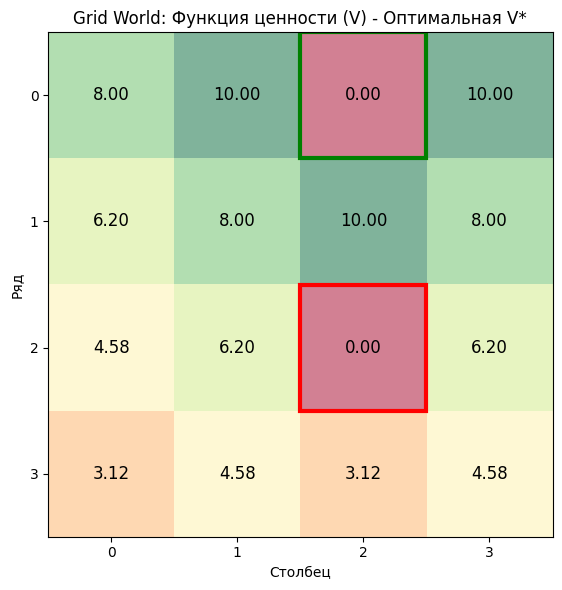

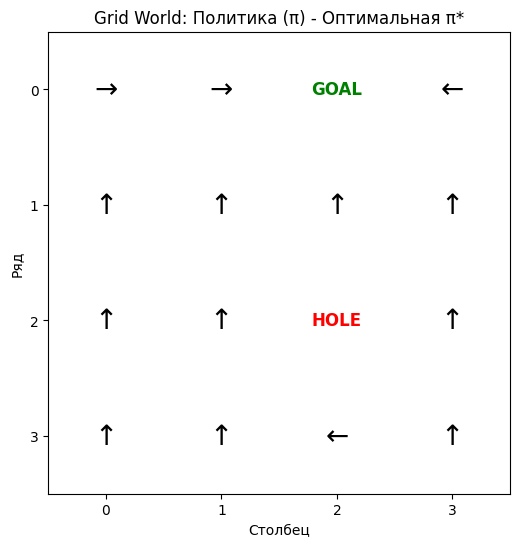

In [7]:
print("Результаты для Grid World (Value Iteration):")
plot_grid_world_v_function(V_star_gw, GRID_SIZE_GW, TERMINAL_STATES_GW, "Оптимальная V*")
plot_grid_world_policy(pi_star_gw, GRID_SIZE_GW, TERMINAL_STATES_GW, "Оптимальная π*")

---

## Задание 2: Policy Iteration на Frozen Lake (детерминированная среда)

Теперь вы реализуете **Policy Iteration (Итерация по политике)**. Этот алгоритм состоит из двух чередующихся шагов:
1.  **Policy Evaluation:** Оценка текущей политики (вычисление $V^{\pi}(s)$).
2.  **Policy Improvement:** Улучшение политики на основе вычисленной функции ценности.

Мы будем использовать среду `FrozenLake-v1` из библиотеки Gymnasium. Сначала рассмотрим её **нескользкий** (детерминированный) вариант: `is_slippery=False`.

Индексы состояний в среде FrozenLake:

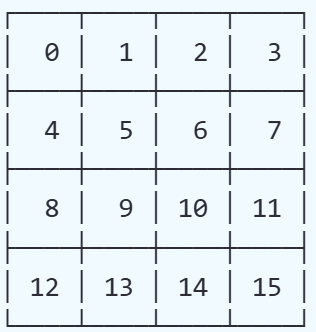

In [8]:
# --- Параметры для Policy Iteration ---
THETA_POLICY_EVAL = 1e-10 # Порог для сходимости оценки функции ценности

### Задача 2.1: Оценка политики (Policy Evaluation)

Допишите код в функции `compute_value_function`. На этом шаге для *заданной* политики $\pi$ вычисляется функция ценности $V^{\pi}(s)$ путём итеративного применения уравнения Беллмана **для ожидания**:

$$V_{k+1}^{\pi}(s) = \sum_{s'} P(s'|s, \pi(s)) \cdot [R(s,a,s') + \gamma V_k^{\pi}(s')]$$

Цикл продолжается до тех пор, пока максимальное изменение ценности состояний ($\|V_{k+1} - V_k\|_{\infty}$) не станет меньше `theta`.

In [9]:
def compute_value_function(policy_indices, env, gamma, theta_eval):
    """
    Оценивает заданную политику (синхронный итеративный вариант).
    Args:
        policy_indices (np.array): 1D массив, где для каждого состояния указан индекс действия.
        env (gym.Env): Среда Gymnasium.
        gamma (float): Коэффициент дисконтирования.
        theta_eval (float): Порог для определения сходимости.
    Returns:
        np.array: Функция ценности V для данной политики.
    """
    V = np.zeros(env.observation_space.n)
    while True:
        V_old = np.copy(V)
        delta = 0
        for state in range(env.observation_space.n):
            action = int(policy_indices[state])
            new_v_s = 0
            # ### ВАШ КОД ЗДЕСЬ ### (Задача 2.1)
            # Рассчитайте новую ценность для `state` (new_v_s),
            # используя уравнение Беллмана для ожидания.
            # Используйте V_old для расчетов на текущей итерации.
            # env.unwrapped.P[state][action] возвращает список [(prob, next_state, reward, done), ...]
            for prob, next_state, reward, done in env.unwrapped.P[state][action]:
                new_v_s += prob * (reward + gamma * V_old[next_state])
            # ### ВАШ КОД ЗАКОНЧИЛСЯ ###
            V[state] = new_v_s
            delta = max(delta, np.abs(V_old[state] - V[state]))
        if delta < theta_eval:
            break
    return V

### Задача 2.2: Улучшение политики (Policy Improvement)

Теперь, имея функцию ценности $V^{\pi}$, улучшите политику, сделав её "жадной" по отношению к $V^{\pi}$. Для каждого состояния $s$ выберите действие, которое максимизирует Q-функцию:
$$\pi'(s) = \arg\max_{a \in A} Q^{\pi}(s,a) = \arg\max_{a \in A} \sum_{s'} P(s'|s, a) \cdot [R(s,a,s') + \gamma V^{\pi}(s')]$$

Вам нужно дописать код в функции `extract_policy_from_v`.

In [10]:
def extract_policy_from_v(value_table, env, gamma):
    """
    Извлекает новую детерминированную политику (1D массив индексов действий)
    на основе функции ценности V.
    Args:
        value_table (np.array): Функция ценности V.
        env (gym.Env): Среда Gymnasium.
        gamma (float): Коэффициент дисконтирования.
    Returns:
        np.array: Новая политика (массив индексов действий).
    """
    policy_indices = np.zeros(env.observation_space.n, dtype=int)
    for state in range(env.observation_space.n):
        Q_table = np.zeros(env.action_space.n)
        # ### ВАШ КОД ЗДЕСЬ ### (Задача 2.2)
        # Для каждого действия `action` в состоянии `state` рассчитайте его Q-значение (Q_table[action]),
        # используя `value_table` (это V-функция).
        for action in range(env.action_space.n):
            for prob, next_state, reward, done in env.unwrapped.P[state][action]:
                Q_table[action] += prob * (reward + gamma * value_table[next_state])
        # ### ВАШ КОД ЗАКОНЧИЛСЯ ###
        policy_indices[state] = np.argmax(Q_table) # Выбираем действие с максимальным Q-значением
    return policy_indices

### Задача 2.3: Основной цикл Policy Iteration
Объедините шаги оценки и улучшения в один цикл. Алгоритм сходится, когда политика перестаёт изменяться после шага улучшения. Допишите код в функции `policy_iteration`.

In [11]:
def policy_iteration(env, gamma, theta_eval, verbose = True):
    """
    Основной алгоритм Policy Iteration.
    Args:
        env (gym.Env): Среда Gymnasium.
        gamma (float): Коэффициент дисконтирования.
        theta_eval (float): Порог для сходимости Policy Evaluation.
        verbose (bool, optional): Если True, выводит отладочную информацию в процессе выполнения: в нашем случае номера итераций, матрицы ценностей и политики
                                 По умолчанию True.
    Returns:
        (np.array, np.array): Оптимальная политика и оптимальная функция ценности.
    """
    old_policy_indices = np.random.randint(0, env.action_space.n, env.observation_space.n)
    no_of_iterations = 200
    V = np.zeros(env.observation_space.n)

    for i in range(no_of_iterations):
        # ### ВАШ КОД ЗДЕСЬ ### (Задача 2.3)
        # 1. Вызовите функцию оценки политики (Policy Evaluation).
        # 2. Вызовите функцию улучшения политики (Policy Improvement).
        # 3. Проверьте, сошлась ли политика. Если да, прервите цикл.
        # 4. Обновите старую политику.

        # 1. Policy Evaluation
        V = compute_value_function(old_policy_indices, env, gamma, theta_eval)

        # 2. Policy Improvement
        new_policy_indices = extract_policy_from_v(V, env, gamma)
        # ### ВАШ КОД ЗАКОНЧИЛСЯ ###

        # Печать промежуточных результатов
        if verbose:
            print(f"--- PI Итерация {i+1} ---")
            print("Функция ценности:")
            print(np.round(V.reshape(4,4), 3))
            print("Политика:")
            print(new_policy_indices.reshape(4,4))

        # ### ВАШ КОД ЗДЕСЬ ### (Продолжение)
        # 3. Проверка на сходимость и обновление
        if np.array_equal(old_policy_indices, new_policy_indices):
           break

        old_policy_indices = new_policy_indices
        # ### ВАШ КОД ЗАКОНЧИЛСЯ ###

    return new_policy_indices, V

### Проверка Задания 2
Алгоритм Policy Iteration для детерминированной среды также сходится к единственной оптимальной политике, хотя путь сходимости может меняться из-за случайной инициализации. Поэтому мы также используем прямые `assert`-ы для проверки финального результата.

In [12]:
# Создаем детерминированную среду
env_no_slip = gym.make('FrozenLake-v1', is_slippery=False, render_mode=None)
GRID_SIZE_FL = int(np.sqrt(env_no_slip.observation_space.n))

# --- Тесты для отдельных функций ---
test_policy_eval = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0])
V_eval_test = compute_value_function(test_policy_eval, env_no_slip, gamma=0.9, theta_eval=1e-10)
assert np.isclose(V_eval_test[0], 0., atol=0.01), f"Ошибка в compute_value_function. V[0] = {V_eval_test[0]:.2f}, ожидалось ~0."
assert np.isclose(V_eval_test[14], 1, atol=0.01), f"Ошибка в compute_value_function. V[14] = {V_eval_test[14]:.2f}, ожидалось ~1"
print("Функция compute_value_function прошла тест.")

policy_impr_test = extract_policy_from_v(V_eval_test, env_no_slip, gamma=0.9)
assert policy_impr_test[6] == 1 and policy_impr_test[1] == 2, "Ошибка в extract_policy_from_v."
print("Функция extract_policy_from_v прошла тест.")

# --- Тест для всего алгоритма Policy Iteration ---
optimal_policy_no_slip, V_optimal_no_slip = policy_iteration(env_no_slip, gamma=0.9, theta_eval=1e-10, verbose=False)
assert np.array_equal(optimal_policy_no_slip[10], 1), "Финальная политика в состоянии 10 для is_slippery=False неверна."
assert np.isclose(V_optimal_no_slip[10], 0.9, atol=0.01), f"Финальная V[0] для is_slippery=False неверна: {V_optimal_no_slip[0]:.2f}, ожидалось ~0.9"

print("\nПоздравляем! Задание 2 выполнено корректно.")
env_no_slip.close()

Функция compute_value_function прошла тест.
Функция extract_policy_from_v прошла тест.

Поздравляем! Задание 2 выполнено корректно.


### Визуализация для Задания 2: Policy Iteration (Нескользкая)

Результаты для Frozen Lake (is_slippery=False):


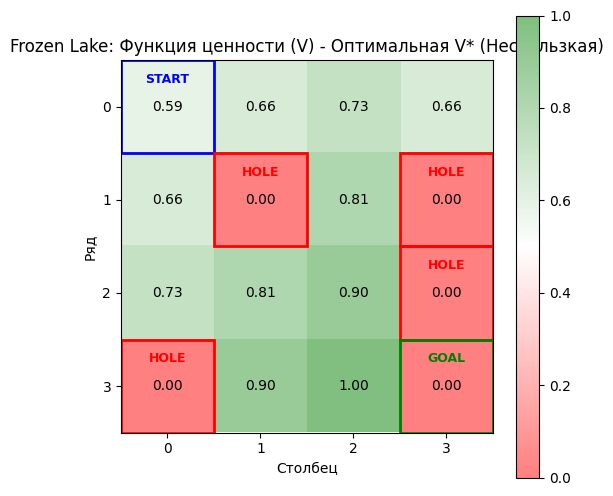

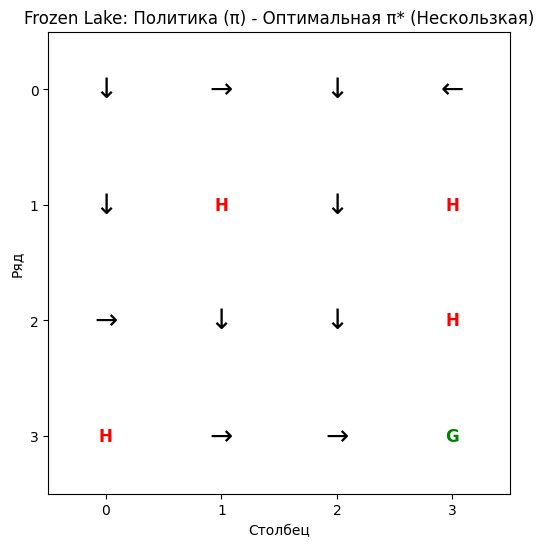

In [13]:
print("Результаты для Frozen Lake (is_slippery=False):")
plot_frozen_lake_v_function(V_optimal_no_slip, env_no_slip, GRID_SIZE_FL, "Оптимальная V* (Нескользкая)")
plot_frozen_lake_policy(optimal_policy_no_slip, env_no_slip, GRID_SIZE_FL, "Оптимальная π* (Нескользкая)")

---

## Задание 3: Policy Iteration на Frozen Lake (стохастическая среда)

Теперь применим тот же самый код к **скользкой** (стохастической) версии `FrozenLake-v1`. В этой среде действия агента не всегда приводят к ожидаемому результату. Например, если агент выбирает идти "вверх", он с некоторой вероятностью может сдвинуться влево или вправо.

### Проверка Задания 3: Статистический анализ

В стохастической среде результат работы Policy Iteration также сходится к одной и той же оптимальной политике, однако из-за случайной инициализации и стохастичности переходов количество итераций может немного меняться. Тем не менее, **финальная V-функция** для оптимальной политики всегда будет одинаковой.

Однако, чтобы продемонстрировать подход, который используется для оценки стохастических алгоритмов (например, Q-learning), мы проведем 100 запусков  и проверим ассерт по медианному значению.

In [14]:
N_RUNS = 100
v_results = []

print(f"Запускаем Policy Iteration {N_RUNS} раз для сбора статистики...")
for i in range(N_RUNS):
    # Создаем среду. Важно создавать ее заново, чтобы сбросить внутренние состояния
    env_slip = gym.make('FrozenLake-v1', is_slippery=True, render_mode=None)
    # Установка random seed для воспроизводимости случайной начальной политики
    np.random.seed(i)

    _, V_optimal_slip = policy_iteration(env_slip, gamma=0.9, theta_eval=1e-10, verbose = False)
    v_results.append(V_optimal_slip[14]) # Собираем V для состояния рядом с целью
    env_slip.close()
    if (i+1) % 10 == 0:
        print(f"Завершено {i+1}/{N_RUNS} запусков...")

v_results = np.array(v_results)
median_v14 = np.median(v_results)

# --- Проверка по медиане ---
print(f"\nМедианное значение для V(S_14) за {N_RUNS} запусков: {median_v14:.4f}")
assert np.isclose(median_v14, 0.64, atol=0.05), f"Медианное значение V[14] неверно: {median_v14:.2f}, ожидалось ~0.64"

print("Поздравляем! Задание 3 выполнено корректно.")

Запускаем Policy Iteration 100 раз для сбора статистики...
Завершено 10/100 запусков...
Завершено 20/100 запусков...
Завершено 30/100 запусков...
Завершено 40/100 запусков...
Завершено 50/100 запусков...
Завершено 60/100 запусков...
Завершено 70/100 запусков...
Завершено 80/100 запусков...
Завершено 90/100 запусков...
Завершено 100/100 запусков...

Медианное значение для V(S_14) за 100 запусков: 0.6390
Поздравляем! Задание 3 выполнено корректно.


### Визуализация для Задания 3: Policy Iteration (Скользкая)
Визуализируем результат одного из последних запусков.


Результаты для Frozen Lake (is_slippery=True):


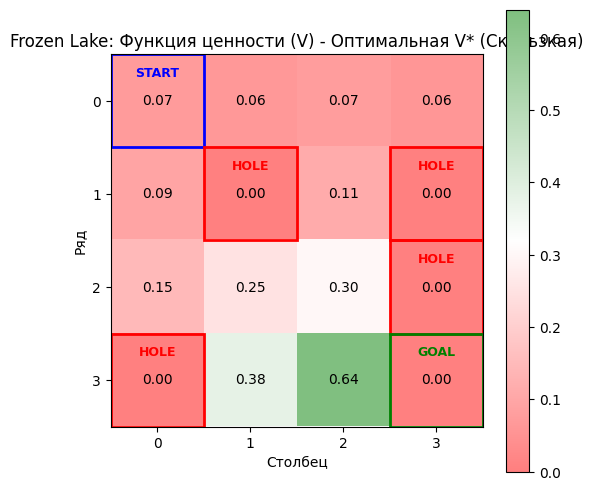

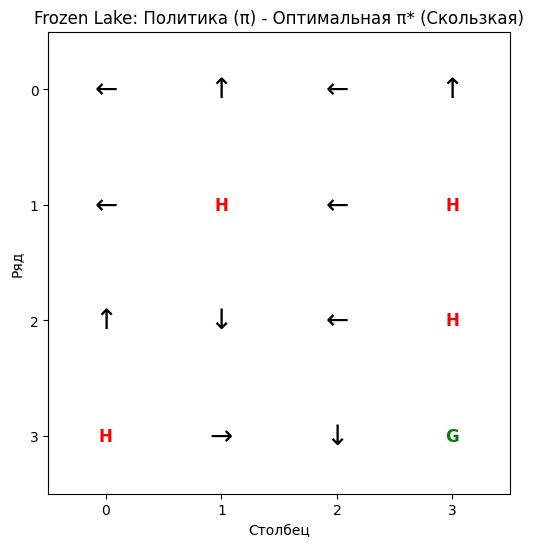

In [15]:
# Для визуализации нам нужен один финальный результат
env_slip_vis = gym.make('FrozenLake-v1', is_slippery=True, render_mode=None)
optimal_policy_slip, V_optimal_slip = policy_iteration(env_slip_vis, gamma=0.9, theta_eval=1e-10, verbose=False)
env_slip_vis.close()

print("\nРезультаты для Frozen Lake (is_slippery=True):")
plot_frozen_lake_v_function(V_optimal_slip, env_slip_vis, GRID_SIZE_FL, "Оптимальная V* (Скользкая)")
plot_frozen_lake_policy(optimal_policy_slip, env_slip_vis, GRID_SIZE_FL, "Оптимальная π* (Скользкая)")

*Обратите внимание на, казалось бы, странные ходы. В некоторых клетках правильная политика может предписывать в стену, например, в положении между дыркой и стеной. Почему? Потому что на “скользком льду” это самый безопасный ход: с вероятностью 1/3 агент попадёт в стену, и с вероятностью 1/3 его снесёт в каждую из перпендикулярных сторон, но при этом он точно не попадёт в дырку*